In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
import itertools

https://www.kaggle.com/ouwyukha/copy-of-predict-movie-ratings/code

In [2]:
df = pd.read_csv('data/train.csv')

In [3]:
df.head()

,ID,user,movie,rating,timestamp
0,1802700,13239,367,5.0,8.452071e+08
1,1290352,9469,6323,3.5,1.120504e+09
2,2660900,19250,364,4.0,8.402181e+08
3,2563669,18581,6281,2.0,1.063980e+09
4,763295,5798,1569,3.0,1.136088e+09


In [4]:
df.user.nunique()

69878

In [5]:
df.movie.nunique()

10650

<AxesSubplot:>

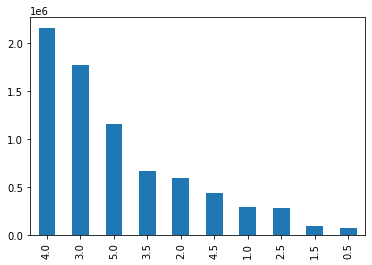

In [8]:
df.rating.value_counts().plot.bar()

### Dataset class

In [197]:
class MovieDataset:
    
    def __init__(self, user, movie, rating):
        self.user = user
        self.movie = movie
        self.rating = rating
        
    def __len__(self):
        return len(self.user)
    
    def __getitem__(self, item):
        
        user = self.user[item]
        movie = self.movie[item]
        rating = self.rating[item]
        
        return {
            'user': torch.tensor(user, dtype=torch.long),
            'movie': torch.tensor(movie, dtype=torch.long),
            'rating': torch.tensor(rating, dtype=torch.float),
        }

In [198]:
encoders={
    'user': sklearn.preprocessing.LabelEncoder(),
    'movie': sklearn.preprocessing.LabelEncoder()
}

df['encoded_user']=encoders['user'].fit_transform(df['user'])
df['encoded_movie']=encoders['movie'].fit_transform(df['movie'])

In [199]:
df_train, df_val = train_test_split(df, test_size=0.2, stratify = df.rating.values)

In [200]:
train_dataset = MovieDataset(df_train.encoded_user.values, df_train.encoded_movie.values, df_train.rating.values)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)

### User - Movie embeddings

In [201]:
emb_size = 64

In [202]:
user_feat = nn.Embedding(df.user.nunique(), emb_size)
movie_feat = nn.Embedding(df.movie.nunique(), emb_size)

### Model definition

In [203]:
class Predictor(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        
        self.lin1 = nn.Linear(2*in_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, 1, bias=False)
        
    def forward(self, user_feat, movie_feat):
        feats = torch.cat([user_feat, movie_feat], dim=1)
        
        h = F.relu(self.lin1(feats))
        h = self.lin2(h)
        
        return h

### Train loop

In [213]:
def train(model, user_feat, movie_feat, loader, criterion, optim):
    model.train()
    
    fin_loss = 0
    
    for data in tqdm.tqdm(loader, total=len(loader)):
        
        optim.zero_grad()
        logits = model(user_feat(data['user']), movie_feat(data['movie']))
        
        _loss = criterion(logits, data['rating'].view(-1,1))
        _loss.backward()
        
        optim.step()
        fin_loss += _loss.item()
        
    return fin_loss / len(loader)     

In [214]:
user_feat

Embedding(69878, 64)

In [215]:
EPOCHS = 50

model = Predictor(64, 32)
user_feat = nn.Embedding(df.user.nunique(), emb_size)
movie_feat = nn.Embedding(df.movie.nunique(), emb_size)

criterion =nn.MSELoss()
optim = torch.optim.Adam(itertools.chain(
                                         model.parameters(),
                                         user_feat.parameters(),
                                         movie_feat.parameters()),
                         lr=3e-4)

In [217]:
user_feat.to_device()

AttributeError: 'Embedding' object has no attribute 'to_device'

In [216]:
for e in range(EPOCHS):
    epoch_loss = train(model, user_feat, movie_feat, train_loader, criterion, optim)
    
    print(f"Epoch {e+1} - MSE: {epoch_loss}")

  6%|██▎                                   | 1460/23438 [00:23<05:52, 62.39it/s]


KeyboardInterrupt: 